# 3. Processing Tweet Text for Candidates

In [1]:
import tweepy, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime as dt

import nltk
import spacy
from nltk.corpus import stopwords
import re

%matplotlib inline

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Load dataframes with Candidate Tweets

In [3]:
mcauliffe_tweets = pd.read_pickle('pickle_files/mcauliffe_tweets_df.pkl')
mcauliffe_tweets.head(2)

,tweet_id,created_at,tweet_text,num_favorites,num_retweets,in_reply_to_screen_name,in_reply_to_tweet_id,user_id,user_name,user_handle,...,qt_tweet_id,qt_tweet_user_id,qt_tweet_user_handle,qt_tweet_text,mentions,hashtags,datetime,mentions_biden,mentions_trump,mentions_opponent
0,1455894456801038346,2021-11-03 13:47:42+00:00,https://t.co/y6DyoHlJPu,6390,957,None,None,19471123,Terry McAuliffe,TerryMcAuliffe,...,None,None,None,None,None,None,2021-11-03 13:47:42,0,0,0
1,1455725530280509441,2021-11-03 02:36:27+00:00,We know that the long term path of Virginia is...,2975,324,TerryMcAuliffe,1455725529110401030,19471123,Terry McAuliffe,TerryMcAuliffe,...,None,None,None,None,None,None,2021-11-03 02:36:27,0,0,0


In [4]:
youngkin_tweets = pd.read_pickle('pickle_files/youngkin_tweets_df.pkl')
murphyNJ_tweets = pd.read_pickle('pickle_files/murphyNJ_tweets_df.pkl')
ciattarelliNJ_tweets = pd.read_pickle('pickle_files/ciattarelliNJ_tweets_df.pkl')

### Remove Unnecessary Columns for Text Analysis

In [5]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


def remove_urls(text):
    """
    cleans urls from spacy cleaned list of tokens
    """
    text = re.sub(r'http\S+', '', text)
    return text


def remove_urls_emojis(df):
    df_text = df[['tweet_id','datetime','user_id','user_handle','tweet_text']].copy()
    df_text['tweet_text_no_emoji'] = df_text.tweet_text.apply(lambda x: deEmojify(x))
    df_text['tweet_text_no_url'] = df_text.tweet_text_no_emoji.apply(lambda x: remove_urls(x))
    
    return df_text

In [6]:
mcauliffe_tweets_text = remove_urls_emojis(mcauliffe_tweets)
mcauliffe_tweets_text.head(1)

,tweet_id,datetime,user_id,user_handle,tweet_text,tweet_text_no_emoji,tweet_text_no_url
0,1455894456801038346,2021-11-03 13:47:42,19471123,TerryMcAuliffe,https://t.co/y6DyoHlJPu,https://t.co/y6DyoHlJPu,


In [7]:
youngkin_tweets_text = remove_urls_emojis(youngkin_tweets)
murphyNJ_tweets_text = remove_urls_emojis(murphyNJ_tweets)
ciattarelliNJ_tweets_text = remove_urls_emojis(ciattarelliNJ_tweets)

## Clean Tweets with Spacy

In [8]:
def remove_spaces(token_list):
    """
    function to remove spaces left over from emoji removal 
    token_list - spacy cleaned list of tokens
    """
    for token in token_list:
        if token == ' ':
            token_list.remove(token)
    return token_list

def remove_rt(token_list):
    """
    function to remove spaces left over from emoji removal 
    token_list - spacy cleaned list of tokens
    """
    for token in token_list:
        if token == 'rt':
            token_list.remove(token)
    return token_list

def remove_mentions(token_list):
    """
    function to remove spaces left over from emoji removal 
    token_list - spacy cleaned list of tokens
    """
    for token in token_list:
        if token[0] == '@':
            token_list.remove(token)
            
    return token_list

def clean_w_spacy(df):
    docs = list(nlp.pipe(df.tweet_text_no_url))
    df['spacy_doc'] = docs
    
    docs_clean = [[w.lemma_.lower() for w in doc if (not w.is_stop and not w.is_punct and not w.like_num) \
               or (w.lemma_=='not')] for doc in docs]
    df['docs_clean'] = docs_clean
    
    df['docs_clean'] = df.docs_clean.apply(lambda x: remove_spaces(x))
    df['docs_clean'] = df.docs_clean.apply(lambda x: remove_rt(x))
    df['docs_clean'] = df.docs_clean.apply(lambda x: remove_mentions(x))
    
    df = df[df.docs_clean.map(lambda x: len(x)) >0].reset_index().drop(columns = ['index'])
    
    return df

In [9]:
nlp = spacy.load('en_core_web_sm')
mcauliffe_tweets_text = clean_w_spacy(mcauliffe_tweets_text)
youngkin_tweets_text = clean_w_spacy(youngkin_tweets_text)
murphyNJ_tweets_text = clean_w_spacy(murphyNJ_tweets_text)
ciattarelliNJ_tweets_text = clean_w_spacy(ciattarelliNJ_tweets_text)

In [10]:
mcauliffe_tweets_text.head(1)

,tweet_id,datetime,user_id,user_handle,tweet_text,tweet_text_no_emoji,tweet_text_no_url,spacy_doc,docs_clean
0,1455725530280509441,2021-11-03 02:36:27,19471123,TerryMcAuliffe,We know that the long term path of Virginia is...,We know that the long term path of Virginia is...,We know that the long term path of Virginia is...,"(We, know, that, the, long, term, path, of, Vi...","[know, long, term, path, virginia, inclusion, ..."


## Sentiment Analysis

Polarity lies between (-1,1), where **<font color = red>-1 defines a negative sentiment</font> and <font color = green>1 defines a positive sentiment.</font>**

Subjectivity lies between (0,1). Subjectivity quantifies the amount of personal opinion and factual information contained in the text. **_The higher subjectivity means that the text contains personal opinion rather than factual information._**

In [11]:
from spacytextblob.spacytextblob import SpacyTextBlob
nlp.add_pipe('spacytextblob');

In [12]:
def get_tweet_polarity(tweet):
    return nlp(tweet)._.polarity
    
def get_tweet_subjectivity(tweet):
    return nlp(tweet)._.subjectivity

def assign_tweet_sentiment(polarity):
    if polarity > 0.1:
        return 'pos'
    elif polarity < -0.1:
        return 'neg'
    else:
        return 'neutral'

def get_tweet_sentiment(df):
    df['polarity'] = df.tweet_text_no_url.apply(lambda x: get_tweet_polarity(x))
    df['subjectivity'] = df.tweet_text_no_url.apply(lambda x: get_tweet_subjectivity(x))
    df['sentiment'] = df.polarity.apply(lambda x: assign_tweet_sentiment(x))
    
    return df

In [13]:
mcauliffe_tweet_sentiment = get_tweet_sentiment(mcauliffe_tweets_text)
youngkin_tweet_sentiment = get_tweet_sentiment(youngkin_tweets_text)
murphyNJ_tweet_sentiment = get_tweet_sentiment(murphyNJ_tweets_text)
ciattarelliNJ_tweet_sentiment = get_tweet_sentiment(ciattarelliNJ_tweets_text)

mcauliffe_tweet_sentiment.head(2)

,tweet_id,datetime,user_id,user_handle,tweet_text,tweet_text_no_emoji,tweet_text_no_url,spacy_doc,docs_clean,polarity,subjectivity,sentiment
0,1455725530280509441,2021-11-03 02:36:27,19471123,TerryMcAuliffe,We know that the long term path of Virginia is...,We know that the long term path of Virginia is...,We know that the long term path of Virginia is...,"(We, know, that, the, long, term, path, of, Vi...","[know, long, term, path, virginia, inclusion, ...",-0.05,0.4,neutral
1,1455725529110401030,2021-11-03 02:36:26,19471123,TerryMcAuliffe,To all my supporters across Virginia who knock...,To all my supporters across Virginia who knock...,To all my supporters across Virginia who knock...,"(To, all, my, supporters, across, Virginia, wh...","[supporter, virginia, knock, door, phone, call...",0.00,0.0,neutral


#### Labeled sentiment breakdown by candidate

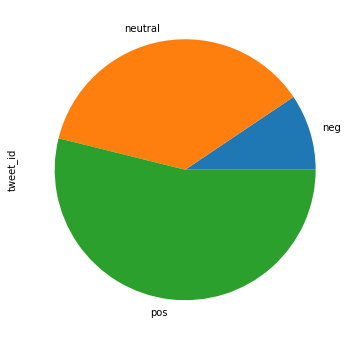

In [14]:
fig = plt.figure(figsize = (6,6))
mcauliffe_tweet_sentiment.groupby(['sentiment']).tweet_id.count().plot(kind = 'pie');

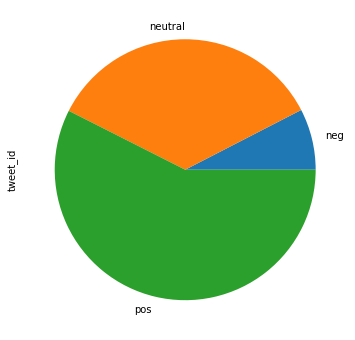

In [15]:
fig = plt.figure(figsize = (6,6))
youngkin_tweet_sentiment.groupby(['sentiment']).tweet_id.count().plot(kind = 'pie');

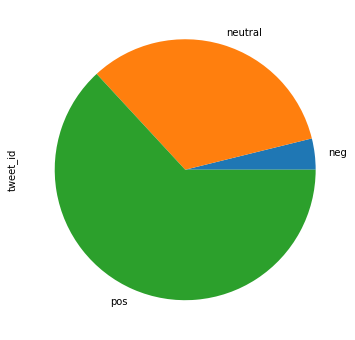

In [16]:
fig = plt.figure(figsize = (6,6))
murphyNJ_tweet_sentiment.groupby(['sentiment']).tweet_id.count().plot(kind = 'pie');

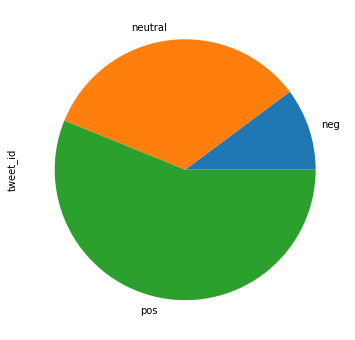

In [17]:
fig = plt.figure(figsize = (6,6))
ciattarelliNJ_tweet_sentiment.groupby(['sentiment']).tweet_id.count().plot(kind = 'pie');

#### VIsualizations

In [18]:
def polarity_sentiment_viz(df, candidate, image_name):
    fig = plt.figure(figsize = (14,6), dpi = 150)
    fig.suptitle('Sentiment of Tweets from '+candidate, fontsize = 20)
    
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    
    cm_1 = plt.cm.get_cmap('RdYlGn')
    
    n, bins, patches = ax1.hist(df.polarity, 25, color = '#e54b22', alpha = 0.8)
    
    bin_centers = 0.5 *(bins[:-1]+ bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)
    
    for c,p in zip(col,patches):
        plt.setp(p, 'facecolor', cm_1(c))
    
    ax1.set_title('Tweet Polarity', fontsize = 15)
    
    #########################
    
    cm_2 = plt.cm.get_cmap('PuOr')
    
    n, bins, patches = ax2.hist(df.subjectivity, 25, color = '#abd1ff', alpha = 0.8)
    
    bin_centers = 0.5 *(bins[:-1]+ bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)
    
    for c,p in zip(col,patches):
        plt.setp(p, 'facecolor', cm_2(c))
        
    ax2.set_title('Tweet Subjectivity', fontsize = 15)
    
    plt.tight_layout(pad = 2)
    plt.savefig(image_name)
    plt.show();

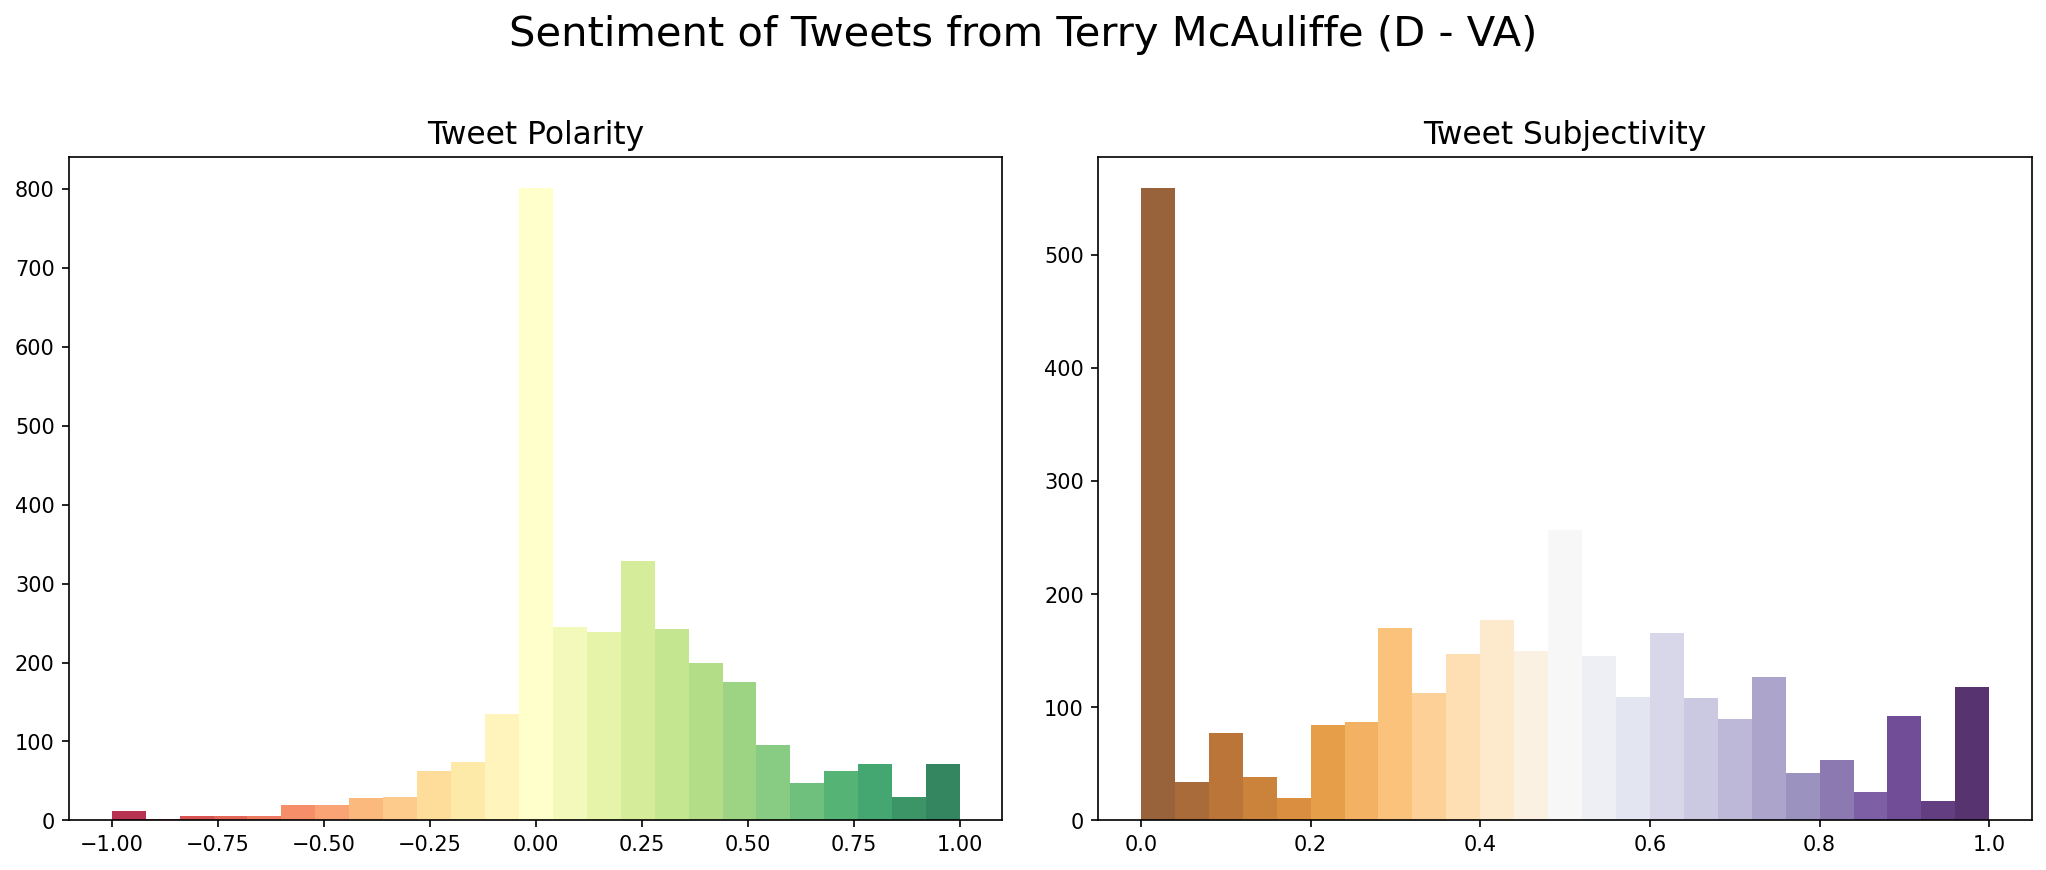

In [19]:
polarity_sentiment_viz(mcauliffe_tweet_sentiment, 'Terry McAuliffe (D - VA)', 'mcauliffe_polarity_sentiment')

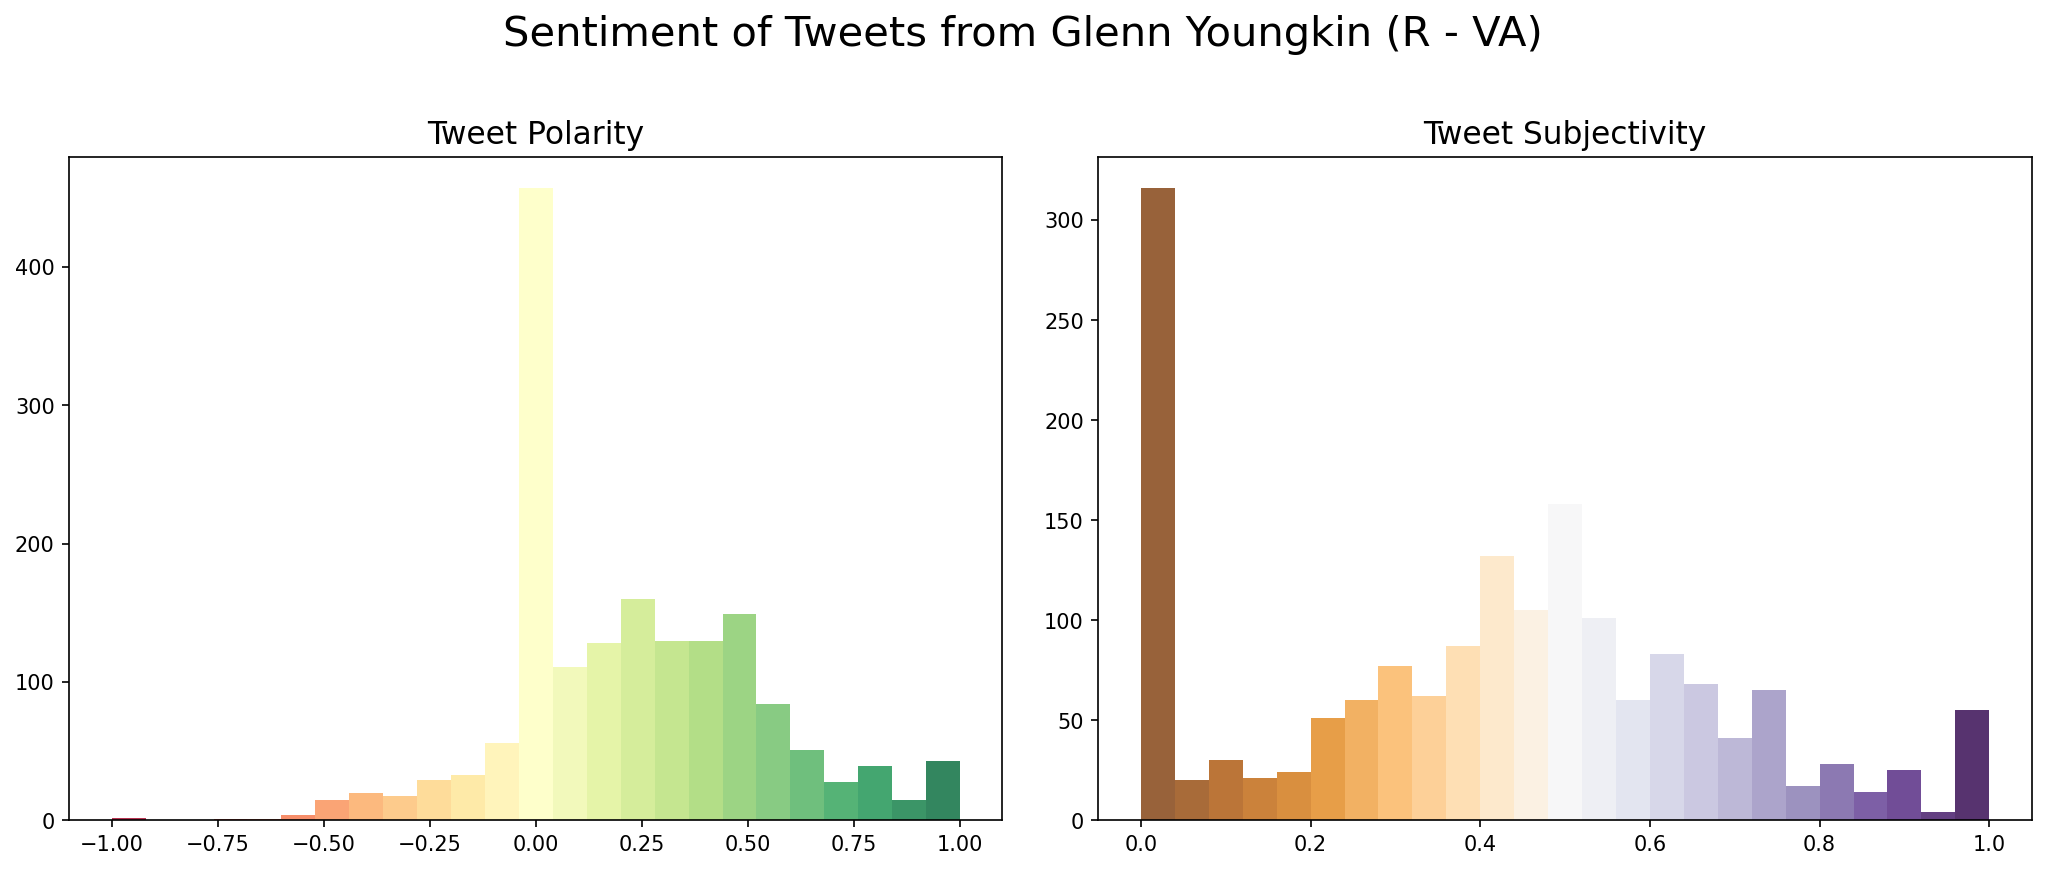

In [20]:
polarity_sentiment_viz(youngkin_tweet_sentiment, 'Glenn Youngkin (R - VA)', 'Youngkin_polarity_sentiment')


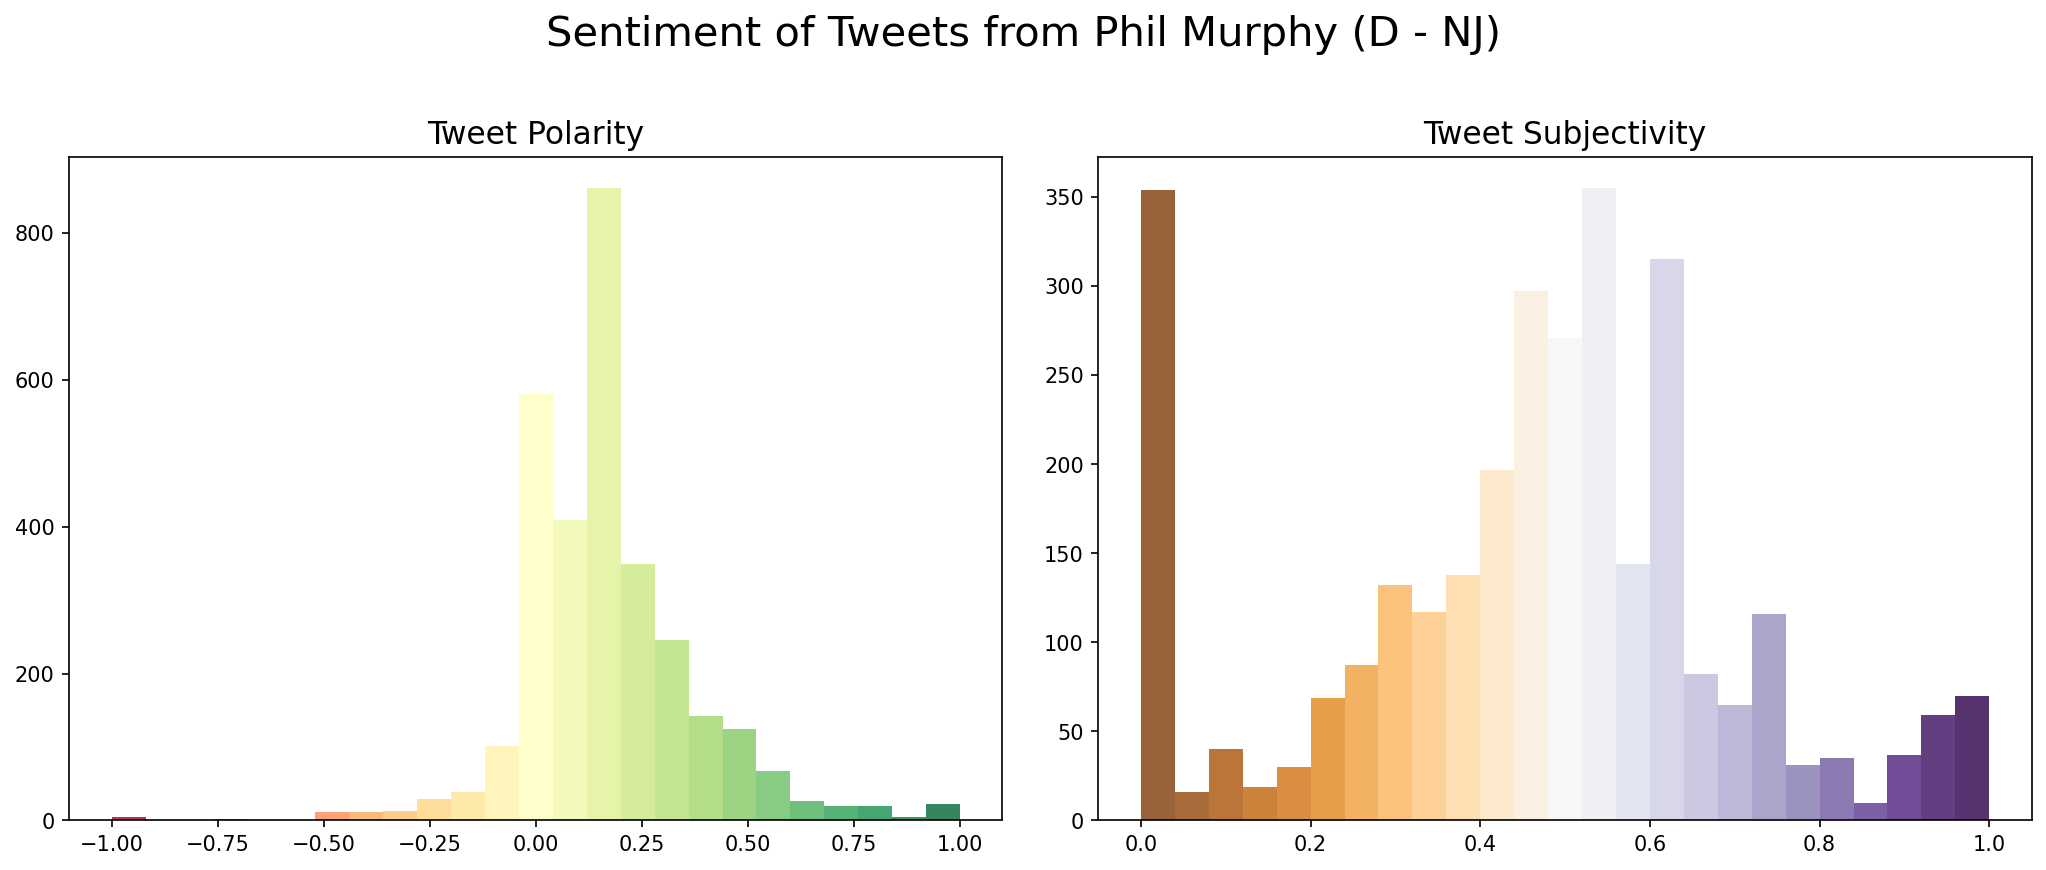

In [21]:
polarity_sentiment_viz(murphyNJ_tweet_sentiment, 'Phil Murphy (D - NJ)', 'Murphy_polarity_sentiment')


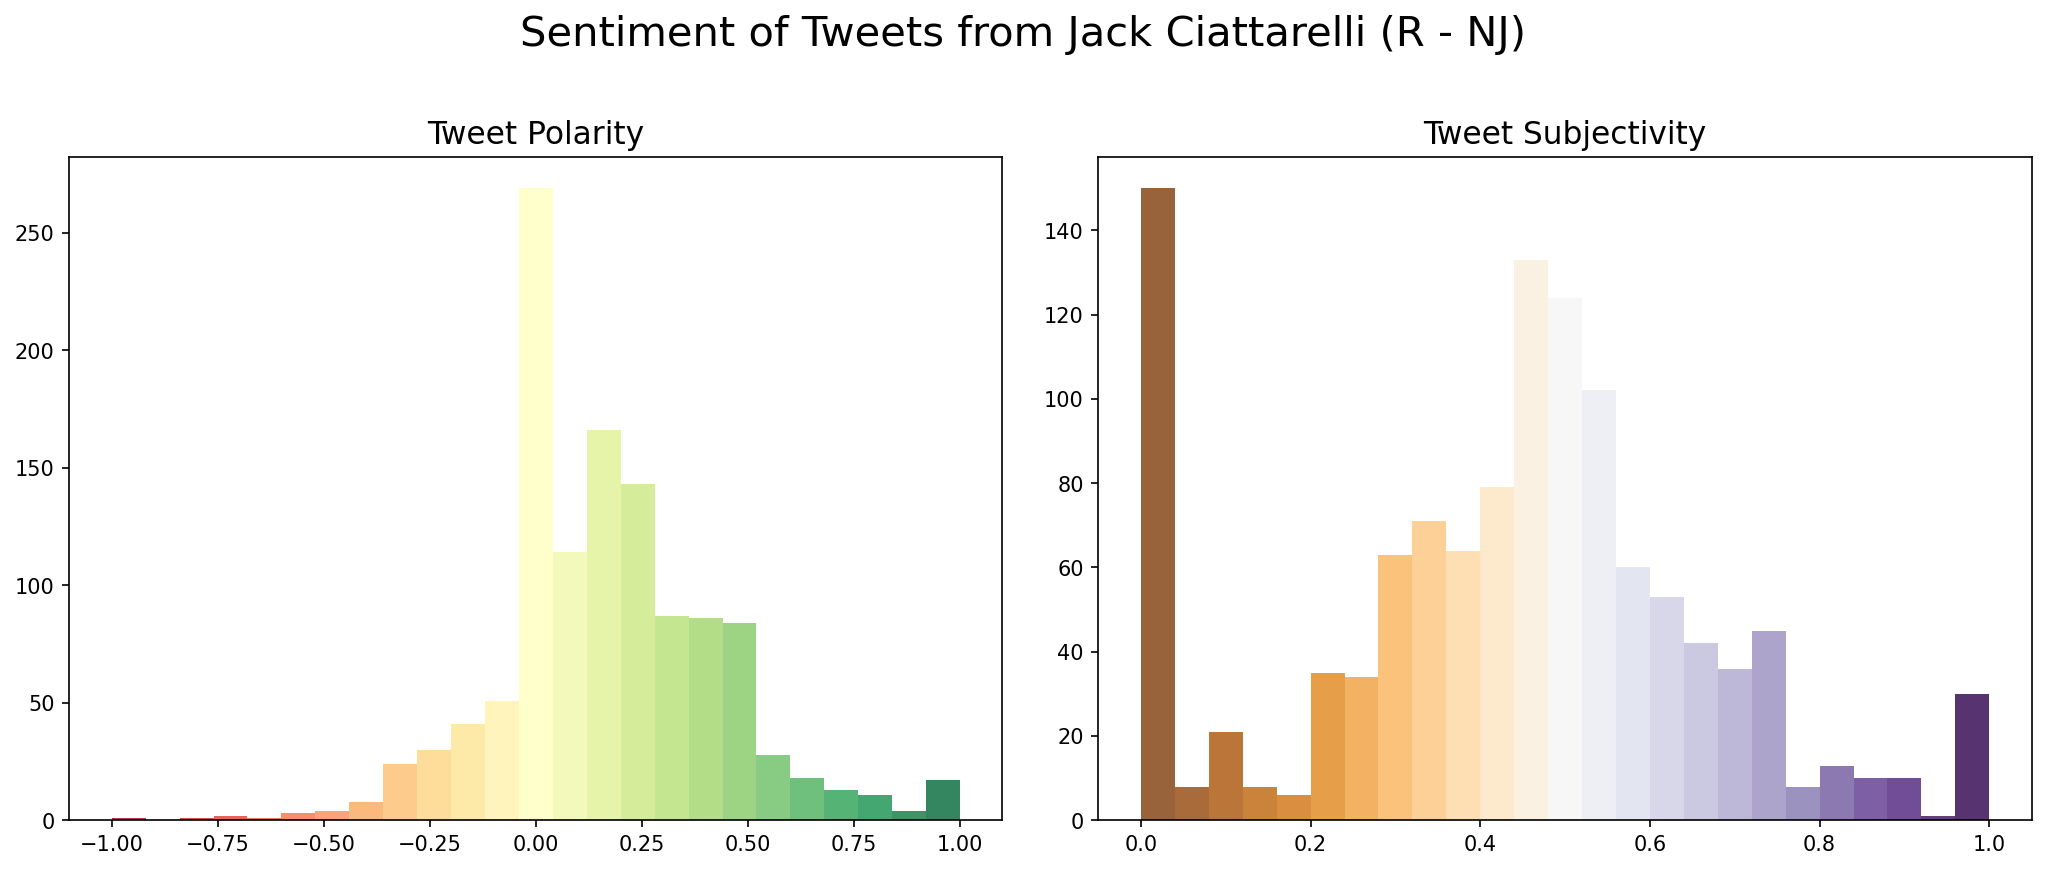

In [22]:
polarity_sentiment_viz(ciattarelliNJ_tweet_sentiment, 'Jack Ciattarelli (R - NJ)', 'Ciattarelli_polarity_sentiment')


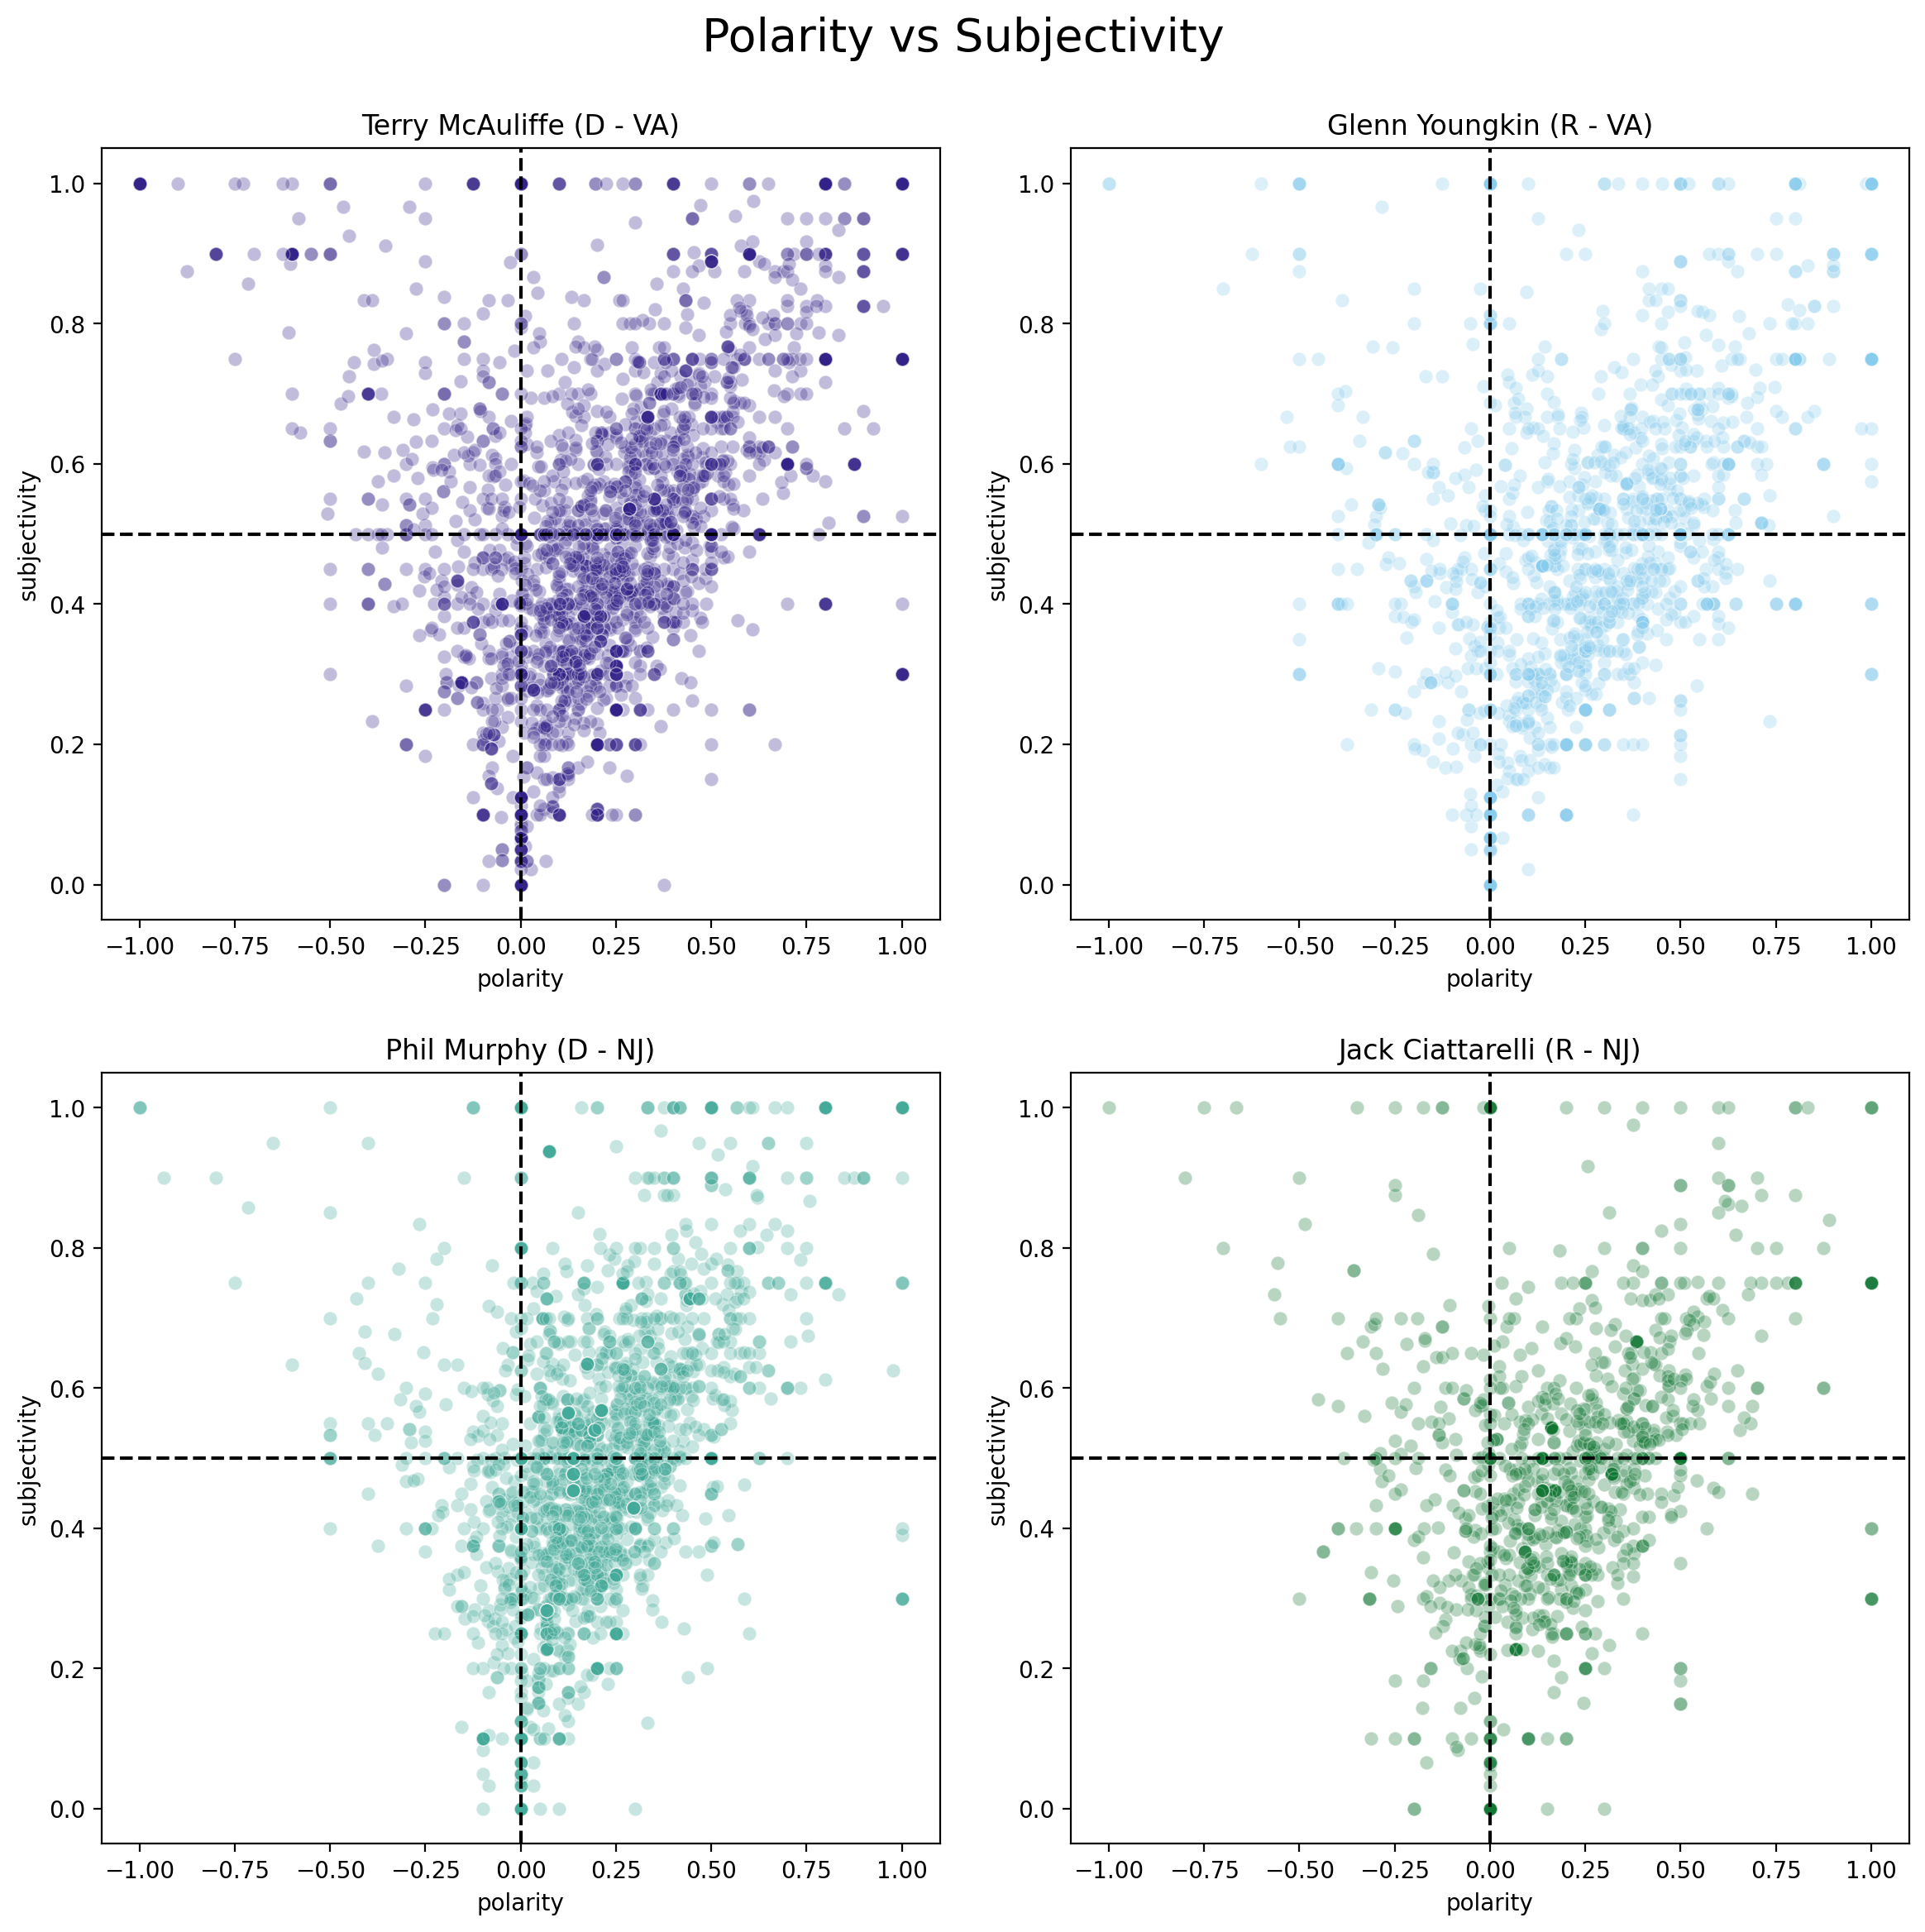

In [23]:
fig = plt.figure(figsize=(12,12), dpi = 200)
fig.suptitle('Polarity vs Subjectivity', fontsize = 20)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)


sns.scatterplot(data=mcauliffe_tweet_sentiment, x='polarity', y='subjectivity', 
                alpha=.3, ax = ax1, color = '#332288')
ax1.axhline(0.5, linestyle='--', color='k')
ax1.axvline(0, linestyle='--', color='k')
ax1.set_title('Terry McAuliffe (D - VA)')

#############
sns.scatterplot(data=youngkin_tweet_sentiment, x='polarity', y='subjectivity', 
                alpha=.3, color = '#88CCEE', ax = ax2)
ax2.axhline(0.5, linestyle='--', color='k')
ax2.axvline(0, linestyle='--', color='k')
ax2.set_title('Glenn Youngkin (R - VA)')

#############
sns.scatterplot(data=murphyNJ_tweet_sentiment, x='polarity', y='subjectivity', 
                alpha=.3, ax = ax3, color = '#44AA99')
ax3.axhline(0.5, linestyle='--', color='k')
ax3.axvline(0, linestyle='--', color='k')
ax3.set_title('Phil Murphy (D - NJ)')

#############
sns.scatterplot(data=ciattarelliNJ_tweet_sentiment, x='polarity', y='subjectivity', 
                alpha=.3, color = '#117733', ax = ax4)
ax4.axhline(0.5, linestyle='--', color='k')
ax4.axvline(0, linestyle='--', color='k')
ax4.set_title('Jack Ciattarelli (R - NJ)')

plt.tight_layout(pad = 2)
plt.savefig('polarity_subjectivity_all.png')
plt.show();

### <font color = gray>*Changes Through Time?*</font>

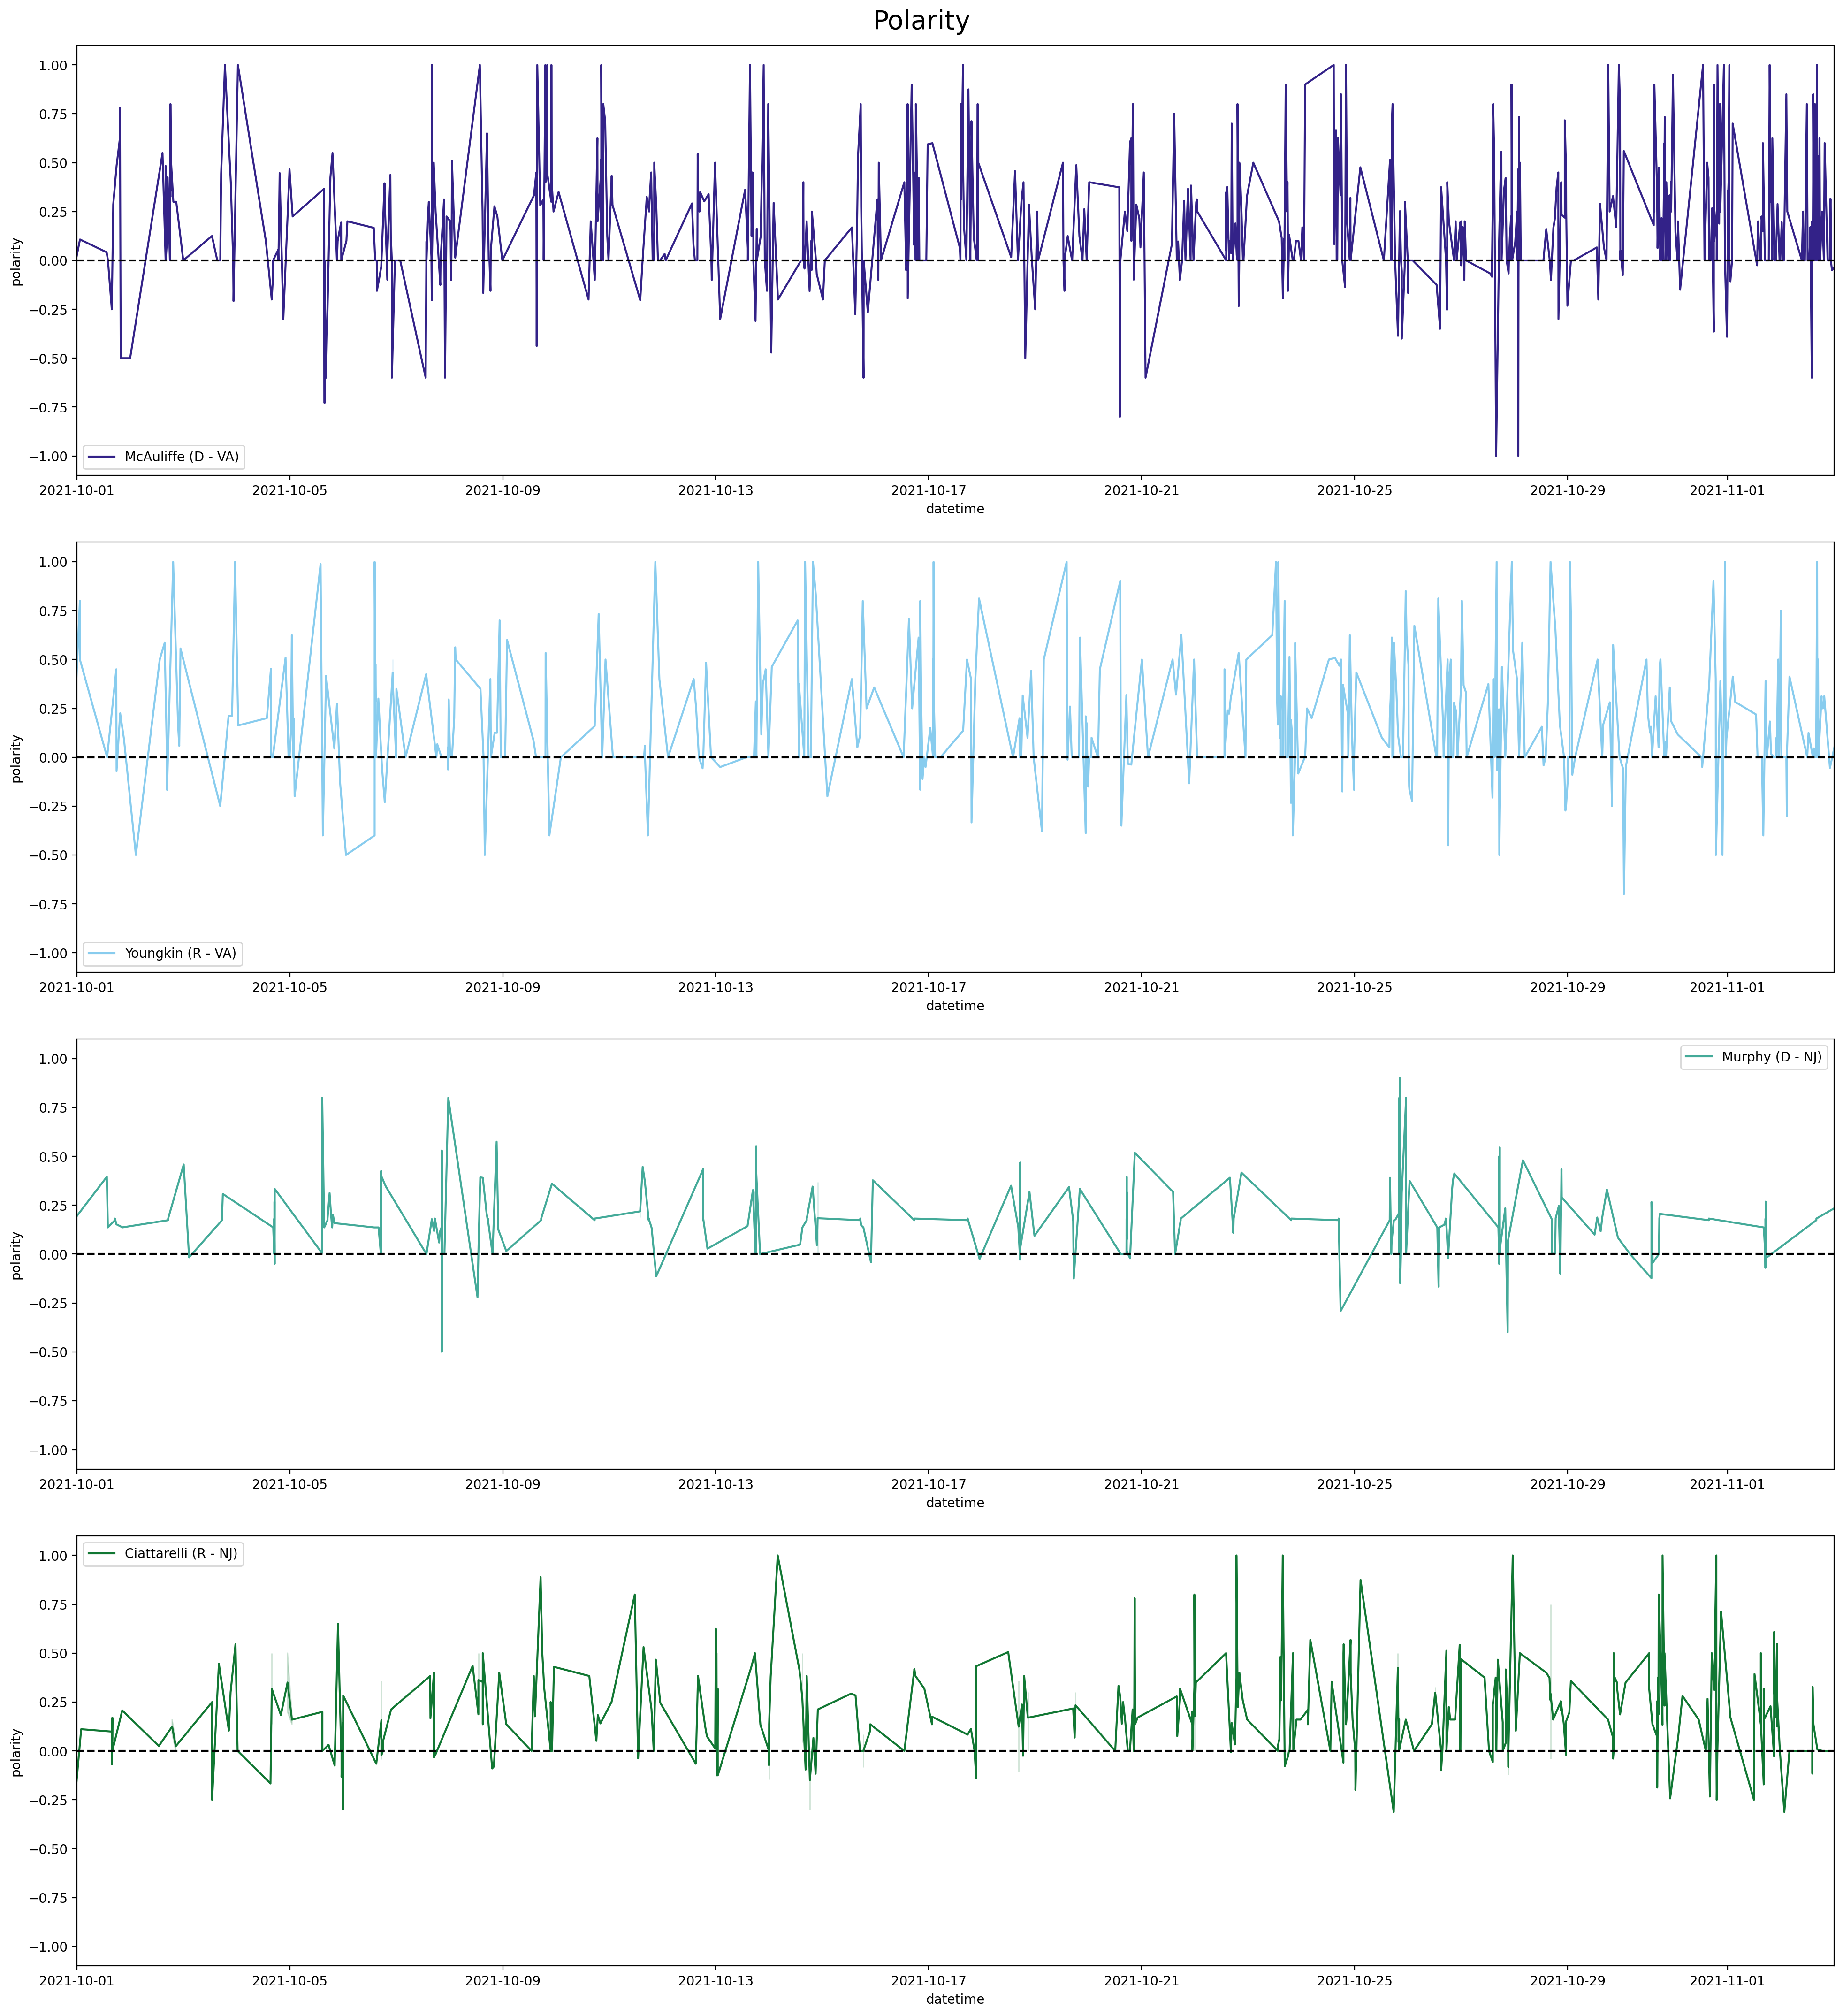

In [24]:
import datetime
fig = plt.figure(figsize=(20,22), dpi = 200)
fig.suptitle('Polarity', fontsize = 20)

ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4)

sns.lineplot(x = 'datetime',  y = 'polarity', data = mcauliffe_tweet_sentiment,
             label = 'McAuliffe (D - VA)',
             ax = ax1, color = '#332288')
ax1.set_xlim([datetime.date(2021, 10, 1), datetime.date(2021, 11, 3)])
ax1.axhline(0, linestyle='--', color='k')


sns.lineplot(x = 'datetime', y = 'polarity', data = youngkin_tweet_sentiment, 
             label = 'Youngkin (R - VA)',
             ax = ax2, color = '#88CCEE')
ax2.set_xlim([datetime.date(2021, 10, 1), datetime.date(2021, 11, 3)])
ax2.axhline(0, linestyle='--', color='k')


sns.lineplot(x = 'datetime', y = 'polarity', data = murphyNJ_tweet_sentiment, 
             label = 'Murphy (D - NJ)',
             ax = ax3, color = '#44AA99')
ax3.set_xlim([datetime.date(2021, 10, 1), datetime.date(2021, 11, 3)])
ax3.axhline(0, linestyle='--', color='k')


sns.lineplot(x = 'datetime', y = 'polarity', data = ciattarelliNJ_tweet_sentiment, 
             label = 'Ciattarelli (R - NJ)',
             ax = ax4, color = '#117733');
ax4.set_xlim([datetime.date(2021, 10, 1), datetime.date(2021, 11, 3)])
ax4.axhline(0, linestyle='--', color='k')


plt.tight_layout(pad = 2)
plt.savefig('polarity_through_time.png')
plt.show();

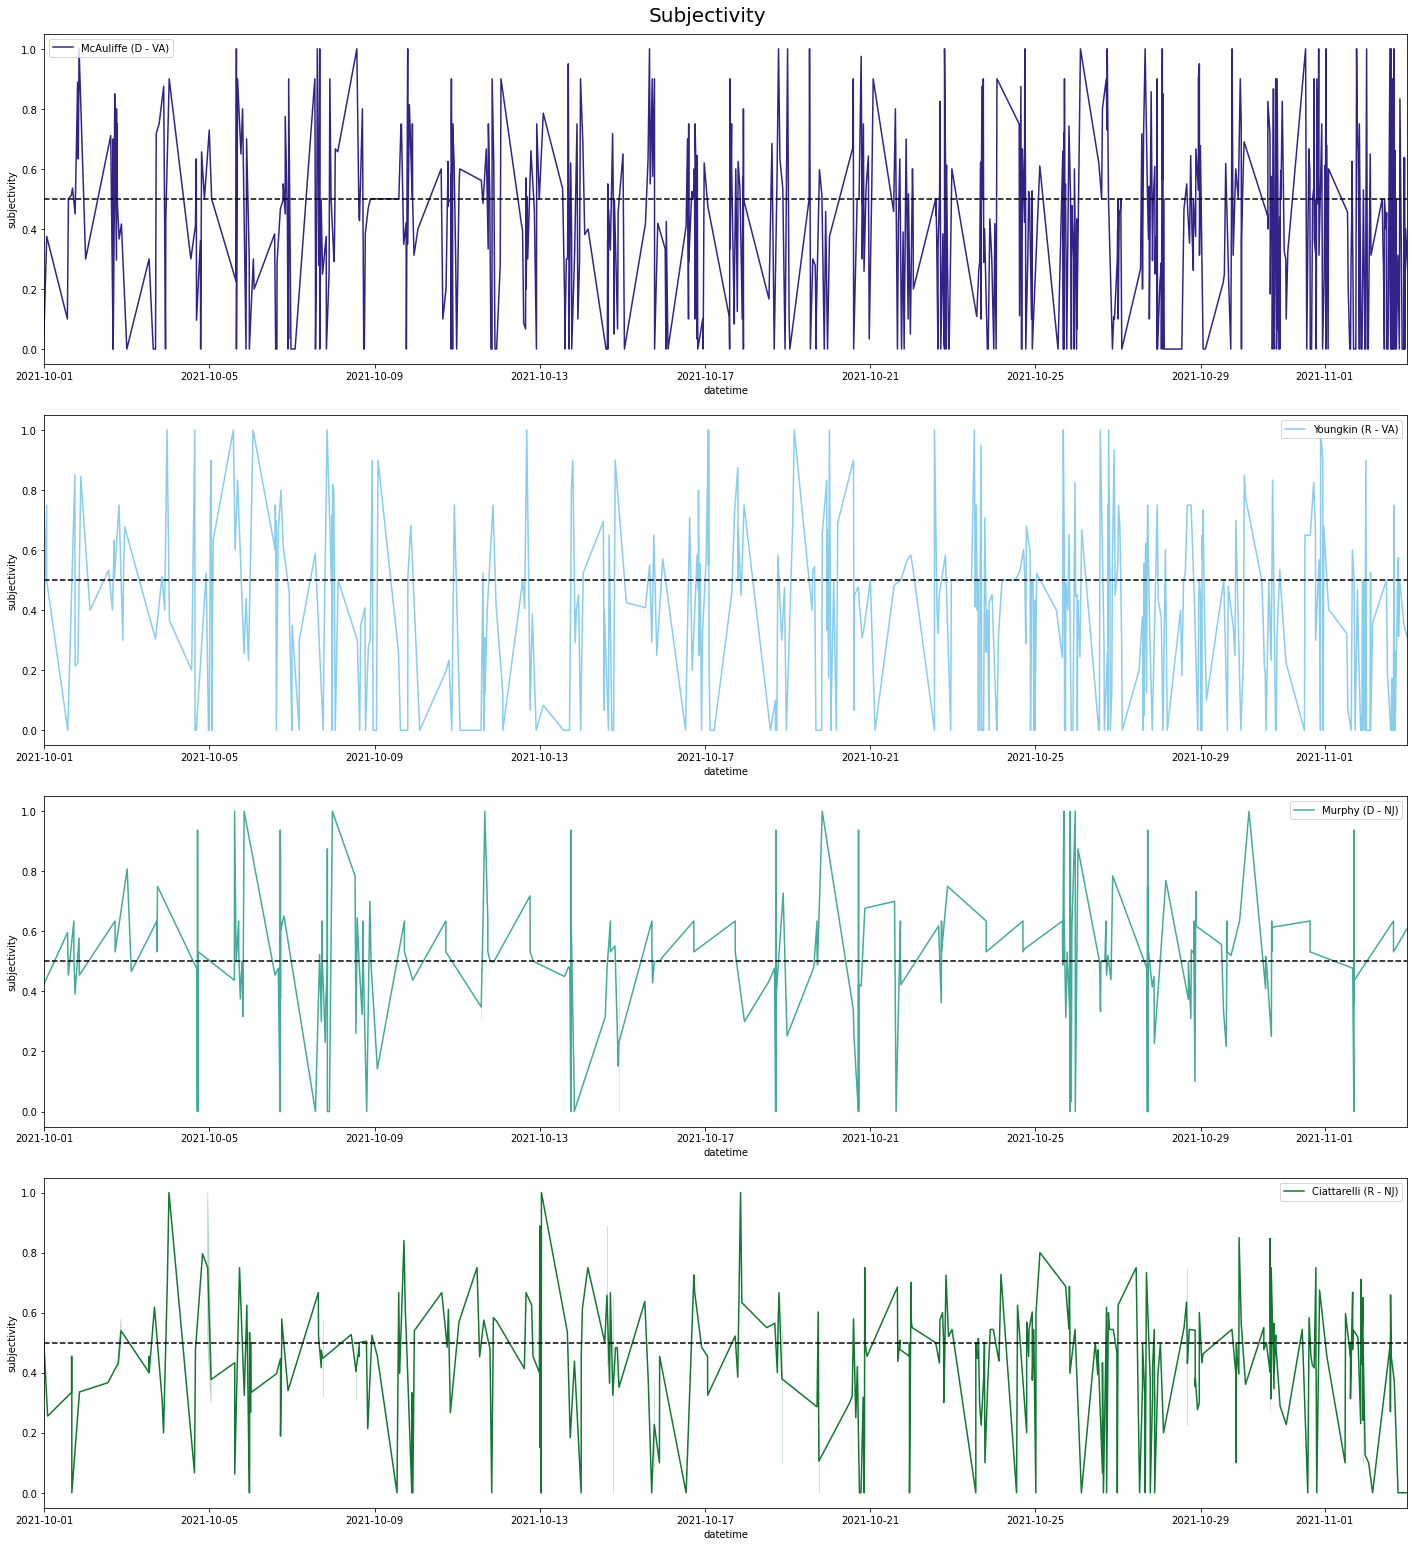

In [25]:
fig = plt.figure(figsize=(20,22))
fig.suptitle('Subjectivity', fontsize = 20)

ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4)

sns.lineplot(x = 'datetime',  y = 'subjectivity', data = mcauliffe_tweet_sentiment,
             label = 'McAuliffe (D - VA)',
             ax = ax1, color = '#332288')
ax1.set_xlim([datetime.date(2021, 10, 1), datetime.date(2021, 11, 3)])
ax1.axhline(0.5, linestyle='--', color='k')


sns.lineplot(x = 'datetime', y = 'subjectivity', data = youngkin_tweet_sentiment, 
             label = 'Youngkin (R - VA)',
             ax = ax2, color = '#88CCEE')
ax2.set_xlim([datetime.date(2021, 10, 1), datetime.date(2021, 11, 3)])
ax2.axhline(0.5, linestyle='--', color='k')


sns.lineplot(x = 'datetime', y = 'subjectivity', data = murphyNJ_tweet_sentiment, 
             label = 'Murphy (D - NJ)',
             ax = ax3, color = '#44AA99')
ax3.set_xlim([datetime.date(2021, 10, 1), datetime.date(2021, 11, 3)])
ax3.axhline(0.5, linestyle='--', color='k')


sns.lineplot(x = 'datetime', y = 'subjectivity', data = ciattarelliNJ_tweet_sentiment, 
             label = 'Ciattarelli (R - NJ)',
             ax = ax4, color = '#117733');
ax4.set_xlim([datetime.date(2021, 10, 1), datetime.date(2021, 11, 3)])
ax4.axhline(0.5, linestyle='--', color='k')


plt.tight_layout(pad = 2)
plt.savefig('subjectivity_through_time.png')
plt.show();

## Topic Modeling

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
def get_doc_term(df):
    tweet_list_clean = [' '.join(doc) for doc in df.docs_clean]

    cv = TfidfVectorizer()
    doc_term_matrix = cv.fit_transform(tweet_list_clean)

    doc_term_df = pd.DataFrame(doc_term_matrix.toarray(), columns=cv.get_feature_names(), 
                            index = df.tweet_id)
    
    return doc_term_matrix, doc_term_df, cv

In [28]:
def test_NMF_topics(df, num_topics, candidate):
    
    doc_term_matrix, doc_term_df, cv = get_doc_term(df)
    
    for val in num_topics:
        nmf = NMF(val, init = 'nndsvda')
        nmf.fit(doc_term_matrix)
        topic_term = nmf.components_
        doc_topic = nmf.transform(doc_term_matrix)
        
        print('Top Terms for ',candidate,': ', val, ' Topics')
        display_topics(nmf, cv.get_feature_names(), 10)
        print('---------------------------')
        print('\n')
        
    #return doc_term_matrix, doc_term_df # only using when we narrow down to final topic #

In [29]:
def test_LSA_topics(df, num_topics):
    
    doc_term_matrix, doc_term_df, cv = get_doc_term(df)
    
    for num in topic_list:
        lsa = TruncatedSVD(num)
        doc_topic = lsa.fit_transform(doc_term_matrix)
        print(num,' Topics:')
        print('Total Explained Variance: ',sum(lsa.explained_variance_ratio_))
        display_topics(lsa,cv.get_feature_names(),8)
        print('---------------------------')
        print('\n')

In [30]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix+1)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

Dont run below code block

In [31]:
mcauliffe_doc_term_mat, mcauliffe_doc_term_df, cv = get_doc_term(mcauliffe_tweet_sentiment)
youngkin_doc_term_mat, youngkin_doc_term_df, cv = get_doc_term(youngkin_tweet_sentiment)
murphyNJ_doc_term_mat, murphyNJ_doc_term_df, cv = get_doc_term(murphyNJ_tweet_sentiment)
ciattarelliNJ_doc_term_mat, ciattarelliNJ_doc_term_df, cv = get_doc_term(ciattarelliNJ_tweet_sentiment)

#### See how LSA and NMF topics compare for small number of topics

In [32]:
topic_list = [5,6]
test_NMF_topics(mcauliffe_tweet_sentiment, topic_list, 'Terry McAuliffe')

Top Terms for  Terry McAuliffe :  5  Topics

Topic  1
virginia, let, big, forward, thank, great, time, ready, work, day

Topic  2
glenn, youngkin, trump, donald, right, ban, abortion, agenda, virginia, want

Topic  3
vote, day, early, election, today, voting, folk, plan, ballot, teamterry

Topic  4
care, health, virginians, economy, affordable, work, access, get, pay, leave

Topic  5
education, world, class, system, investment, teacher, invest, child, pay, school
---------------------------


Top Terms for  Terry McAuliffe :  6  Topics

Topic  1
virginia, let, big, forward, thank, great, time, ready, work, day

Topic  2
glenn, youngkin, trump, donald, agenda, run, dangerous, want, not, lie

Topic  3
vote, day, early, today, election, folk, plan, teamterry, ballot, voting

Topic  4
care, health, economy, virginians, affordable, work, get, pay, covid, leave

Topic  5
education, world, class, system, investment, teacher, invest, child, pay, school

Topic  6
right, abortion, voting, fight,

In [33]:
topic_list = [5,6]
test_LSA_topics(mcauliffe_tweet_sentiment, topic_list)

5  Topics:
Total Explained Variance:  0.04334925814110324

Topic  1
virginia, glenn, let, youngkin, vote, plan, right, governor

Topic  2
glenn, youngkin, trump, donald, right, abortion, ban, vote

Topic  3
vote, day, early, great, virginia, today, let, thank

Topic  4
vote, care, health, right, access, affordable, early, plan

Topic  5
education, vote, world, class, plan, system, investment, teacher
---------------------------


6  Topics:
Total Explained Variance:  0.05047918527200099

Topic  1
virginia, glenn, let, youngkin, vote, plan, right, governor

Topic  2
glenn, youngkin, trump, donald, right, abortion, ban, vote

Topic  3
vote, day, early, virginia, great, today, let, thank

Topic  4
vote, care, health, right, access, affordable, early, voting

Topic  5
education, vote, world, class, plan, system, investment, school

Topic  6
virginia, education, right, world, class, let, abortion, system
---------------------------




#### I'm gonna go ahead and choose NMF

In [34]:
nmf_topic_num = [5,6,7,8,9,10]
test_NMF_topics(mcauliffe_tweet_sentiment, nmf_topic_num, 'Terry McAuliffe')

Top Terms for  Terry McAuliffe :  5  Topics

Topic  1
virginia, let, big, forward, thank, great, time, ready, work, day

Topic  2
glenn, youngkin, trump, donald, right, ban, abortion, agenda, virginia, want

Topic  3
vote, day, early, election, today, voting, folk, plan, ballot, teamterry

Topic  4
care, health, virginians, economy, affordable, work, access, get, pay, leave

Topic  5
education, world, class, system, investment, teacher, invest, child, pay, school
---------------------------


Top Terms for  Terry McAuliffe :  6  Topics

Topic  1
virginia, let, big, forward, thank, great, time, ready, work, day

Topic  2
glenn, youngkin, trump, donald, agenda, run, dangerous, want, not, lie

Topic  3
vote, day, early, today, election, folk, plan, teamterry, ballot, voting

Topic  4
care, health, economy, virginians, affordable, work, get, pay, covid, leave

Topic  5
education, world, class, system, investment, teacher, invest, child, pay, school

Topic  6
right, abortion, voting, fight,

In [35]:
test_NMF_topics(youngkin_tweet_sentiment, nmf_topic_num, 'Glenn Youngkin')

Top Terms for  Glenn Youngkin :  5  Topics

Topic  1
winwithglenn, day, new, join, tour, vote, bring, event, virginia, bus

Topic  2
thank, support, vagov, hard, love, enforcement, law, appreciate, senator, work

Topic  3
mcauliffe, terry, vagov, parent, say, governor, virginia, want, school, abortion

Topic  4
work, virginia, good, place, live, family, raise, governor, virginians, america

Topic  5
sign, delegate, great, convention, win, folk, campaign, trail, morning, november
---------------------------


Top Terms for  Glenn Youngkin :  6  Topics

Topic  1
winwithglenn, day, join, tour, new, vote, event, bus, bring, rsvp

Topic  2
thank, support, vagov, hard, work, love, senator, appreciate, come, go

Topic  3
mcauliffe, terry, vagov, say, parent, abortion, want, child, watch, education

Topic  4
work, good, live, place, raise, family, virginia, america, commonwealth, virginians

Topic  5
sign, delegate, great, convention, win, folk, campaign, trail, morning, november

Topic  6
vir

In [36]:
test_NMF_topics(murphyNJ_tweet_sentiment, [4,5,6,7,8,9,10], 'Phil Murphy')

Top Terms for  Phil Murphy :  4  Topics

Topic  1
new, dose, administer, vaccine, learn, fully, vaccinate, jersey, update, study

Topic  2
test, positive, death, total, new, pcr, antigen, confirm, probable, covid19

Topic  3
covid, 19, hold, watch, briefing, death, confirm, cumulative, sadly, report

Topic  4
youtube, twitter, facebook, pm, join, 00, briefing, live, covid19, today
---------------------------


Top Terms for  Phil Murphy :  5  Topics

Topic  1
new, dose, administer, vaccine, learn, fully, vaccinate, jersey, update, study

Topic  2
test, positive, total, new, pcr, antigen, death, covid19, confirmed, probable

Topic  3
hold, briefing, watch, 19, covid, live, relate, vaccinated, announce, receive

Topic  4
youtube, twitter, facebook, pm, join, 00, briefing, live, covid19, today

Topic  5
death, confirm, cumulative, sadly, report, covid, additional, bring, number, 19
---------------------------


Top Terms for  Phil Murphy :  6  Topics

Topic  1
new, dose, administer, vacci

In [37]:
test_NMF_topics(ciattarelliNJ_tweet_sentiment, nmf_topic_num, 'Jack Ciattarelli')

Top Terms for  Jack Ciattarelli :  5  Topics

Topic  1
new, jersey, business, state, fix, taxis, plan, thank, nj, jack

Topic  2
event, day, facebook, page, date, scroll, desktop, check, stay, upcoming

Topic  3
tune, live, join, et, listen, 30, tomorrow, miss, morning, 1210wpht

Topic  4
day, election, vote, poll, worker, voting, early, person, location, general

Topic  5
murphy, phil, governor, amp, home, woman, nursing, not, let, state
---------------------------


Top Terms for  Jack Ciattarelli :  6  Topics

Topic  1
new, jersey, business, fix, thank, jack, state, small, great, governor

Topic  2
event, day, facebook, page, date, desktop, scroll, check, stay, upcoming

Topic  3
tune, live, join, et, listen, 30, tomorrow, miss, morning, 1210wpht

Topic  4
day, election, vote, poll, worker, voting, early, person, location, general

Topic  5
murphy, phil, governor, amp, home, woman, nursing, let, time, not

Topic  6
taxis, plan, property, lower, state, learn, nj, school, tax, intervi

### Define final topic numbers for each candidate

In [38]:
def get_final_topics(df, num_topics, column_labels, candidate):
    tweet_list_clean = [' '.join(doc) for doc in df.docs_clean]

    cv = TfidfVectorizer()
    doc_term_matrix = cv.fit_transform(tweet_list_clean)

    doc_term_df = pd.DataFrame(doc_term_matrix.toarray(), columns=cv.get_feature_names(), 
                            index = df.tweet_id)
    
    nmf = NMF(num_topics, init = 'nndsvda')
    nmf.fit(doc_term_matrix)
    topic_term = nmf.components_
    doc_topic = nmf.transform(doc_term_matrix)

    print('Top Terms for ',candidate,': ', num_topics, ' Topics')
    display_topics(nmf, cv.get_feature_names(), 10, column_labels)
    print('---------------------------')
    print('\n')
        
    topics_terms = nmf.components_
    doc_topics = nmf.transform(doc_term_matrix)
    
    doc_topics_df = pd.DataFrame(doc_topics.round(5),
             index = df.tweet_id,
             columns = column_labels)
    
    return doc_topics, doc_topics_df

In [39]:
mcauliffe_topics = ['positive_virginia', 'negative_to_opponent', 'GOTV', 'health_care', 'education_investments',
                   'reproductive_rights','economy','clean_energy']
mcauliffe_doc_topics, mcauliffe_doc_topics_df = get_final_topics(mcauliffe_tweet_sentiment,8,mcauliffe_topics, 
                                                                candidate = 'Terry McAuliffe')

print(mcauliffe_doc_topics_df.shape)
mcauliffe_doc_topics_df.head(3)

Top Terms for  Terry McAuliffe :  8  Topics

Topic: ' positive_virginia '
virginia, let, big, forward, thank, great, day, time, work, ready

Topic: ' negative_to_opponent '
glenn, youngkin, trump, donald, agenda, run, dangerous, want, not, lie

Topic: ' GOTV '
vote, day, early, election, today, plan, folk, teamterry, ballot, voting

Topic: ' health_care '
care, health, affordable, access, wage, pay, family, leave, minimum, virginian

Topic: ' education_investments '
education, world, class, system, investment, teacher, child, invest, pay, school

Topic: ' reproductive_rights '
right, abortion, voting, ban, governor, reproductive, fight, choose, protect, attack

Topic: ' economy '
economy, covid, get, build, plan, post, strong, equitable, virginians, lift

Topic: ' clean_energy '
clean, energy, create, job, future, climate, emission, change, good, reduce
---------------------------


(3005, 8)


,positive_virginia,negative_to_opponent,GOTV,health_care,education_investments,reproductive_rights,economy,clean_energy
tweet_id,,,,,,,,
1455725530280509441,0.01582,0.00509,0.00000,0.01172,0.00476,0.02727,0.00000,0.00193
1455725529110401030,0.02490,0.00534,0.00488,0.00000,0.00575,0.00000,0.00000,0.00000
1455725527390621700,0.00000,0.01865,0.09692,0.01680,0.00702,0.01719,0.01864,0.00000


In [40]:
youngkin_topics = ['campaign_event', 'thank_supporters', 'negative_to_opponent', 'positive_virginia', 
                   'GOTV', 'economy']
youngkin_doc_topics, youngkin_doc_topics_df = get_final_topics(youngkin_tweet_sentiment,6,youngkin_topics,
                                                              candidate = 'Glenn Youngkin')

print(youngkin_doc_topics_df.shape)
youngkin_doc_topics_df.head(3)

Top Terms for  Glenn Youngkin :  6  Topics

Topic: ' campaign_event '
winwithglenn, day, join, tour, new, vote, event, bus, bring, rsvp

Topic: ' thank_supporters '
thank, support, vagov, hard, work, love, senator, appreciate, come, go

Topic: ' negative_to_opponent '
mcauliffe, terry, vagov, say, parent, abortion, want, child, watch, education

Topic: ' positive_virginia '
work, good, live, place, raise, family, virginia, america, commonwealth, virginians

Topic: ' GOTV '
sign, delegate, great, convention, win, folk, campaign, trail, morning, november

Topic: ' economy '
virginia, governor, business, law, enforcement, stand, virginians, job, support, economy
---------------------------


(1704, 6)


,campaign_event,thank_supporters,negative_to_opponent,positive_virginia,GOTV,economy
tweet_id,,,,,,
1456033930281472003,0.01559,0.00197,0.00229,0.04765,0.02817,0.02829
1455982196100042755,0.06930,0.06991,0.00000,0.10711,0.00000,0.03741
1455765518242177024,0.00355,0.00000,0.00000,0.01626,0.00000,0.15505


In [41]:
murphyNJ_topics = ['vaccines', 'covid_testing', 'news_briefing', 'casual_briefing', 'negative_covid']
murphyNJ_doc_topics, murphyNJ_doc_topics_df = get_final_topics(murphyNJ_tweet_sentiment,5,murphyNJ_topics,
                                                              candidate = 'Phil Murphy')

print(murphyNJ_doc_topics_df.shape)
murphyNJ_doc_topics_df.head(3)

Top Terms for  Phil Murphy :  5  Topics

Topic: ' vaccines '
new, dose, administer, vaccine, learn, fully, vaccinate, jersey, update, study

Topic: ' covid_testing '
test, positive, total, new, pcr, antigen, death, covid19, confirmed, probable

Topic: ' news_briefing '
hold, briefing, watch, 19, covid, live, relate, vaccinated, announce, receive

Topic: ' casual_briefing '
youtube, twitter, facebook, pm, join, 00, briefing, live, covid19, today

Topic: ' negative_covid '
death, confirm, cumulative, sadly, report, covid, additional, bring, number, 19
---------------------------


(3086, 5)


,vaccines,covid_testing,news_briefing,casual_briefing,negative_covid
tweet_id,,,,,
1459261168267186182,0.00462,0.00000,0.00000,0.01505,0.00099
1459250713100496897,0.00081,0.00000,0.00026,0.00328,0.00123
1459228412803960833,0.01077,0.00844,0.00000,0.01454,0.00000


In [42]:
ciattarelliNJ_topics = ['im_running', 'where_to_find', 'events', 'GOTV', 'negative_to_opponent',
                   'economy_taxes','small_business']
ciattarelliNJ_doc_topics, ciattarelliNJ_doc_topics_df = get_final_topics(ciattarelliNJ_tweet_sentiment,
                                                                         7,ciattarelliNJ_topics,
                                                                        candidate = 'Jack Ciattarelli')

print(ciattarelliNJ_doc_topics_df.shape)
ciattarelliNJ_doc_topics_df.head(3)

Top Terms for  Jack Ciattarelli :  7  Topics

Topic: ' im_running '
new, jersey, fix, jack, ciattarelli, republican, governor, people, state, well

Topic: ' where_to_find '
event, day, facebook, page, date, desktop, scroll, stay, upcoming, check

Topic: ' events '
tune, live, join, et, listen, 30, tomorrow, miss, 1210wpht, morning

Topic: ' GOTV '
day, election, poll, vote, worker, voting, person, early, general, location

Topic: ' negative_to_opponent '
murphy, phil, governor, amp, home, woman, nursing, let, time, not

Topic: ' economy_taxes '
taxis, plan, property, lower, state, learn, school, nj, tax, issue

Topic: ' small_business '
business, thank, great, small, county, support, today, nj, amp, owner
---------------------------


(1206, 7)


,im_running,where_to_find,events,GOTV,negative_to_opponent,economy_taxes,small_business
tweet_id,,,,,,,
1457776239830134786,0.07902,0.0151,0.00000,0.01604,0.00000,0.00000,0.00000
1456376805510815752,0.03754,0.0000,0.00542,0.00305,0.01866,0.00047,0.02050
1456030544970592267,0.00397,0.0000,0.00150,0.01794,0.00140,0.00000,0.00801


## Prepare Doc-Topic dataframe for modeling

In [43]:
def get_engagement_modeling_dataframe(tweet_dataframe, docs_topics):
    engagement_df = tweet_dataframe[['tweet_id','datetime','user_handle', 'user_followers',
                                            'num_favorites','num_retweets','mentions_biden',
                                           'mentions_trump','mentions_opponent']].copy()
    
    topic_engagement = pd.merge(docs_topics, engagement_df, how = "inner", 
                                      on = 'tweet_id')
    topic_engagement['engagement'] = topic_engagement['num_favorites'] + (2 * topic_engagement['num_retweets'])
    
    return topic_engagement

In [44]:
mcauliffe_sentiment =  mcauliffe_tweet_sentiment[['tweet_id','polarity','subjectivity']]
mcauliffe_engagement_modeling = get_engagement_modeling_dataframe(mcauliffe_tweets, mcauliffe_doc_topics_df)
mcauliffe_engagement_modeling = pd.merge(mcauliffe_engagement_modeling, 
                                         mcauliffe_sentiment, on = 'tweet_id')
mcauliffe_engagement_modeling.head(2)

,tweet_id,positive_virginia,negative_to_opponent,GOTV,health_care,education_investments,reproductive_rights,economy,clean_energy,datetime,user_handle,user_followers,num_favorites,num_retweets,mentions_biden,mentions_trump,mentions_opponent,engagement,polarity,subjectivity
0,1455725530280509441,0.01582,0.00509,0.00000,0.01172,0.00476,0.02727,0.0,0.00193,2021-11-03 02:36:27,TerryMcAuliffe,125813,2975,324,0,0,0,3623,-0.05,0.4
1,1455725529110401030,0.02490,0.00534,0.00488,0.00000,0.00575,0.00000,0.0,0.00000,2021-11-03 02:36:26,TerryMcAuliffe,125813,2859,288,0,0,0,3435,0.00,0.0


In [45]:
youngkin_sentiment =  youngkin_tweet_sentiment[['tweet_id','polarity','subjectivity']]
youngkin_engagement_modeling = get_engagement_modeling_dataframe(youngkin_tweets, youngkin_doc_topics_df)
youngkin_engagement_modeling = pd.merge(youngkin_engagement_modeling, 
                                         youngkin_sentiment, on = 'tweet_id')
youngkin_engagement_modeling.head(2)

,tweet_id,campaign_event,thank_supporters,negative_to_opponent,positive_virginia,GOTV,economy,datetime,user_handle,user_followers,num_favorites,num_retweets,mentions_biden,mentions_trump,mentions_opponent,engagement,polarity,subjectivity
0,1456033930281472003,0.01559,0.00197,0.00229,0.04765,0.02817,0.02829,2021-11-03 23:01:55,GlennYoungkin,154711,26339,2412,0,0,0,31163,0.466667,0.683333
1,1455982196100042755,0.06930,0.06991,0.00000,0.10711,0.00000,0.03741,2021-11-03 19:36:21,GlennYoungkin,154711,59226,6076,0,0,0,71378,0.109848,0.727273


In [46]:
murphyNJ_sentiment =  murphyNJ_tweet_sentiment[['tweet_id','polarity','subjectivity']]
murphyNJ_engagement_modeling = get_engagement_modeling_dataframe(murphyNJ_tweets, murphyNJ_doc_topics_df)
murphyNJ_engagement_modeling = pd.merge(murphyNJ_engagement_modeling, 
                                         murphyNJ_sentiment, on = 'tweet_id')
murphyNJ_engagement_modeling.head(2)

,tweet_id,vaccines,covid_testing,news_briefing,casual_briefing,negative_covid,datetime,user_handle,user_followers,num_favorites,num_retweets,mentions_biden,mentions_trump,mentions_opponent,engagement,polarity,subjectivity
0,1459261168267186182,0.00462,0.0,0.00000,0.01505,0.00099,2021-11-12 20:45:48,GovMurphy,405360,48,16,0,0,0,80,0.0,0.5
1,1459250713100496897,0.00081,0.0,0.00026,0.00328,0.00123,2021-11-12 20:04:16,GovMurphy,405360,249,25,0,0,0,299,0.4,0.9


In [47]:
ciattarelliNJ_sentiment =  ciattarelliNJ_tweet_sentiment[['tweet_id','polarity','subjectivity']]
ciattarelliNJ_engagement_modeling = get_engagement_modeling_dataframe(ciattarelliNJ_tweets, 
                                                                      ciattarelliNJ_doc_topics_df)
ciattarelliNJ_engagement_modeling = pd.merge(ciattarelliNJ_engagement_modeling, 
                                         ciattarelliNJ_sentiment, on = 'tweet_id')
ciattarelliNJ_engagement_modeling.head(2)

,tweet_id,im_running,where_to_find,events,GOTV,negative_to_opponent,economy_taxes,small_business,datetime,user_handle,user_followers,num_favorites,num_retweets,mentions_biden,mentions_trump,mentions_opponent,engagement,polarity,subjectivity
0,1457776239830134786,0.07902,0.0151,0.00000,0.01604,0.00000,0.00000,0.0000,2021-11-08 18:25:14,Jack4NJ,36077,1105,319,0,0,0,1743,0.136364,0.454545
1,1456376805510815752,0.03754,0.0000,0.00542,0.00305,0.01866,0.00047,0.0205,2021-11-04 21:44:23,Jack4NJ,36077,17031,6374,0,0,0,29779,0.450000,0.750000


In [48]:
print(mcauliffe_engagement_modeling.shape)
print(youngkin_engagement_modeling.shape)
print(murphyNJ_engagement_modeling.shape)
print(ciattarelliNJ_engagement_modeling.shape)

(3005, 20)
(1704, 18)
(3086, 17)
(1206, 19)


In [49]:
mcauliffe_engagement_modeling.to_pickle('pickle_files/mcauliffe_engagement_modeling.pkl')
youngkin_engagement_modeling.to_pickle('pickle_files/youngkin_engagement_modeling.pkl')
murphyNJ_engagement_modeling.to_pickle('pickle_files/murphyNJ_engagement_modeling.pkl')
ciattarelliNJ_engagement_modeling.to_pickle('pickle_files/ciattarelliNJ_engagement_modeling.pkl')